In [1]:

import datetime
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DATA_DIR = os.path.join("..", "..", "data")

In [3]:
fp = os.path.join(DATA_DIR, "hydrograph-excel-sheet-tp-cleaned.xlsx")
xl = pd.ExcelFile(fp)
gages = xl.sheet_names
hydro_data = {s: xl.parse(s) for s in gages}

In [4]:
def flatten_sheet(sheet_name: str, src_data: dict):
    src_df = src_data[sheet_name]
    
    # Check lengths of columns, some contain only notes so will be
    # much less than 100 and need to be dropped. Most columns
    # should have 365/366 values but a few are missing and need to be filled.
    col_lengths = {c: sum(src_df[c].notna()) for c in src_df.columns}
    keep_cols = [c for c, l in col_lengths.items() if l > 100]
    
    # Check columns are all in the correct order to combine:
    assert "time" in keep_cols[0].lower()
    correct_order = {"time": "ft", "ft": "discharge", "discharge": "time"}
    for i, col in enumerate(keep_cols[:-1]):
        next_col = keep_cols[i+1]
        for key in correct_order.keys():
            if key in col.lower():
                should_be = correct_order[key]
                assert should_be in next_col.lower(), sheet_name
    
    # Iterate through columns and collect data:
    data_subsets = list()
    for start_col in range(0, len(keep_cols), 3):
        df_columns = keep_cols[start_col: start_col+3]
        subset = src_df[df_columns]
        rename = dict(zip(subset.columns, ["time", "ft", "m3"]))
        subset = subset.rename(columns=rename).dropna(how="all")
        data_subsets.append(subset)
        
    # Combine to a single df:
    final =  pd.concat(data_subsets).reset_index(drop=True)
    final["gage"] = sheet_name
    return final

In [5]:
all_sheets = list()
for sname in gages:
    all_sheets.append(flatten_sheet(sname, hydro_data)) 
df = pd.concat(all_sheets).reset_index(drop=True)

In [6]:
df.dtypes

time    datetime64[ns]
ft             float64
m3             float64
gage            object
dtype: object

In [7]:
# Reindex with a row for each date and gage id:
min_date, max_date = min(df["time"]), max(df["time"])
all_dates = [min_date.to_pydatetime()]
while all_dates[-1] < max_date:
    all_dates.append(all_dates[-1] + datetime.timedelta(days=1))
    
full_index = list(itertools.product(df["gage"].unique(), all_dates))
df = df.set_index(["gage", "time"])
df = df.reindex(full_index)

In [8]:
# Check that metre - feet ratio is constant (i.e. no bad data):
ratios = (df["ft"] / df["m3"]).dropna().unique()
a = np.array(ratios[0])
np.allclose(a, ratios[1])

True

In [9]:
gage_avg = df.groupby(["gage"])["m3"].mean()

In [10]:
def plot_daily_discharge():
    fig, axes = plt.subplots(len(gages), 1, figsize=(12, 22), dpi=200)
    min_date, max_date = min(df.index.levels[1]), max(df.index.levels[1])
    xticks = [dt for dt in df.loc["11402000"].index if dt.day == 1 and dt.month == 1]
    for gage, ax in zip(gages, axes.flatten()):
        ax.plot(df.loc[gage, "m3"], label="Daily Discharge", color="b", linewidth=1)
        ax.hlines(gage_avg[gage], xmin=min_date, xmax=max_date, 
                  color="r", linestyle="--", label="Gage Mean", linewidth=1)
        ax.set_xticks(xticks)
        ax.set_xticklabels([dt.year for dt in xticks], rotation=90, fontsize=9)
        ax.set_xlim(min_date, max_date)
        ax.set_ylim(0, ax.get_ylim()[1])
        ax.set_title(f"Gage {gage}")
        ax.legend()
        ax.set_ylabel("Discharge (m^3)", fontsize=8)
    fig.suptitle("Daily m^3 Discharge", y=0.91)
    fig.subplots_adjust(hspace=0.5)

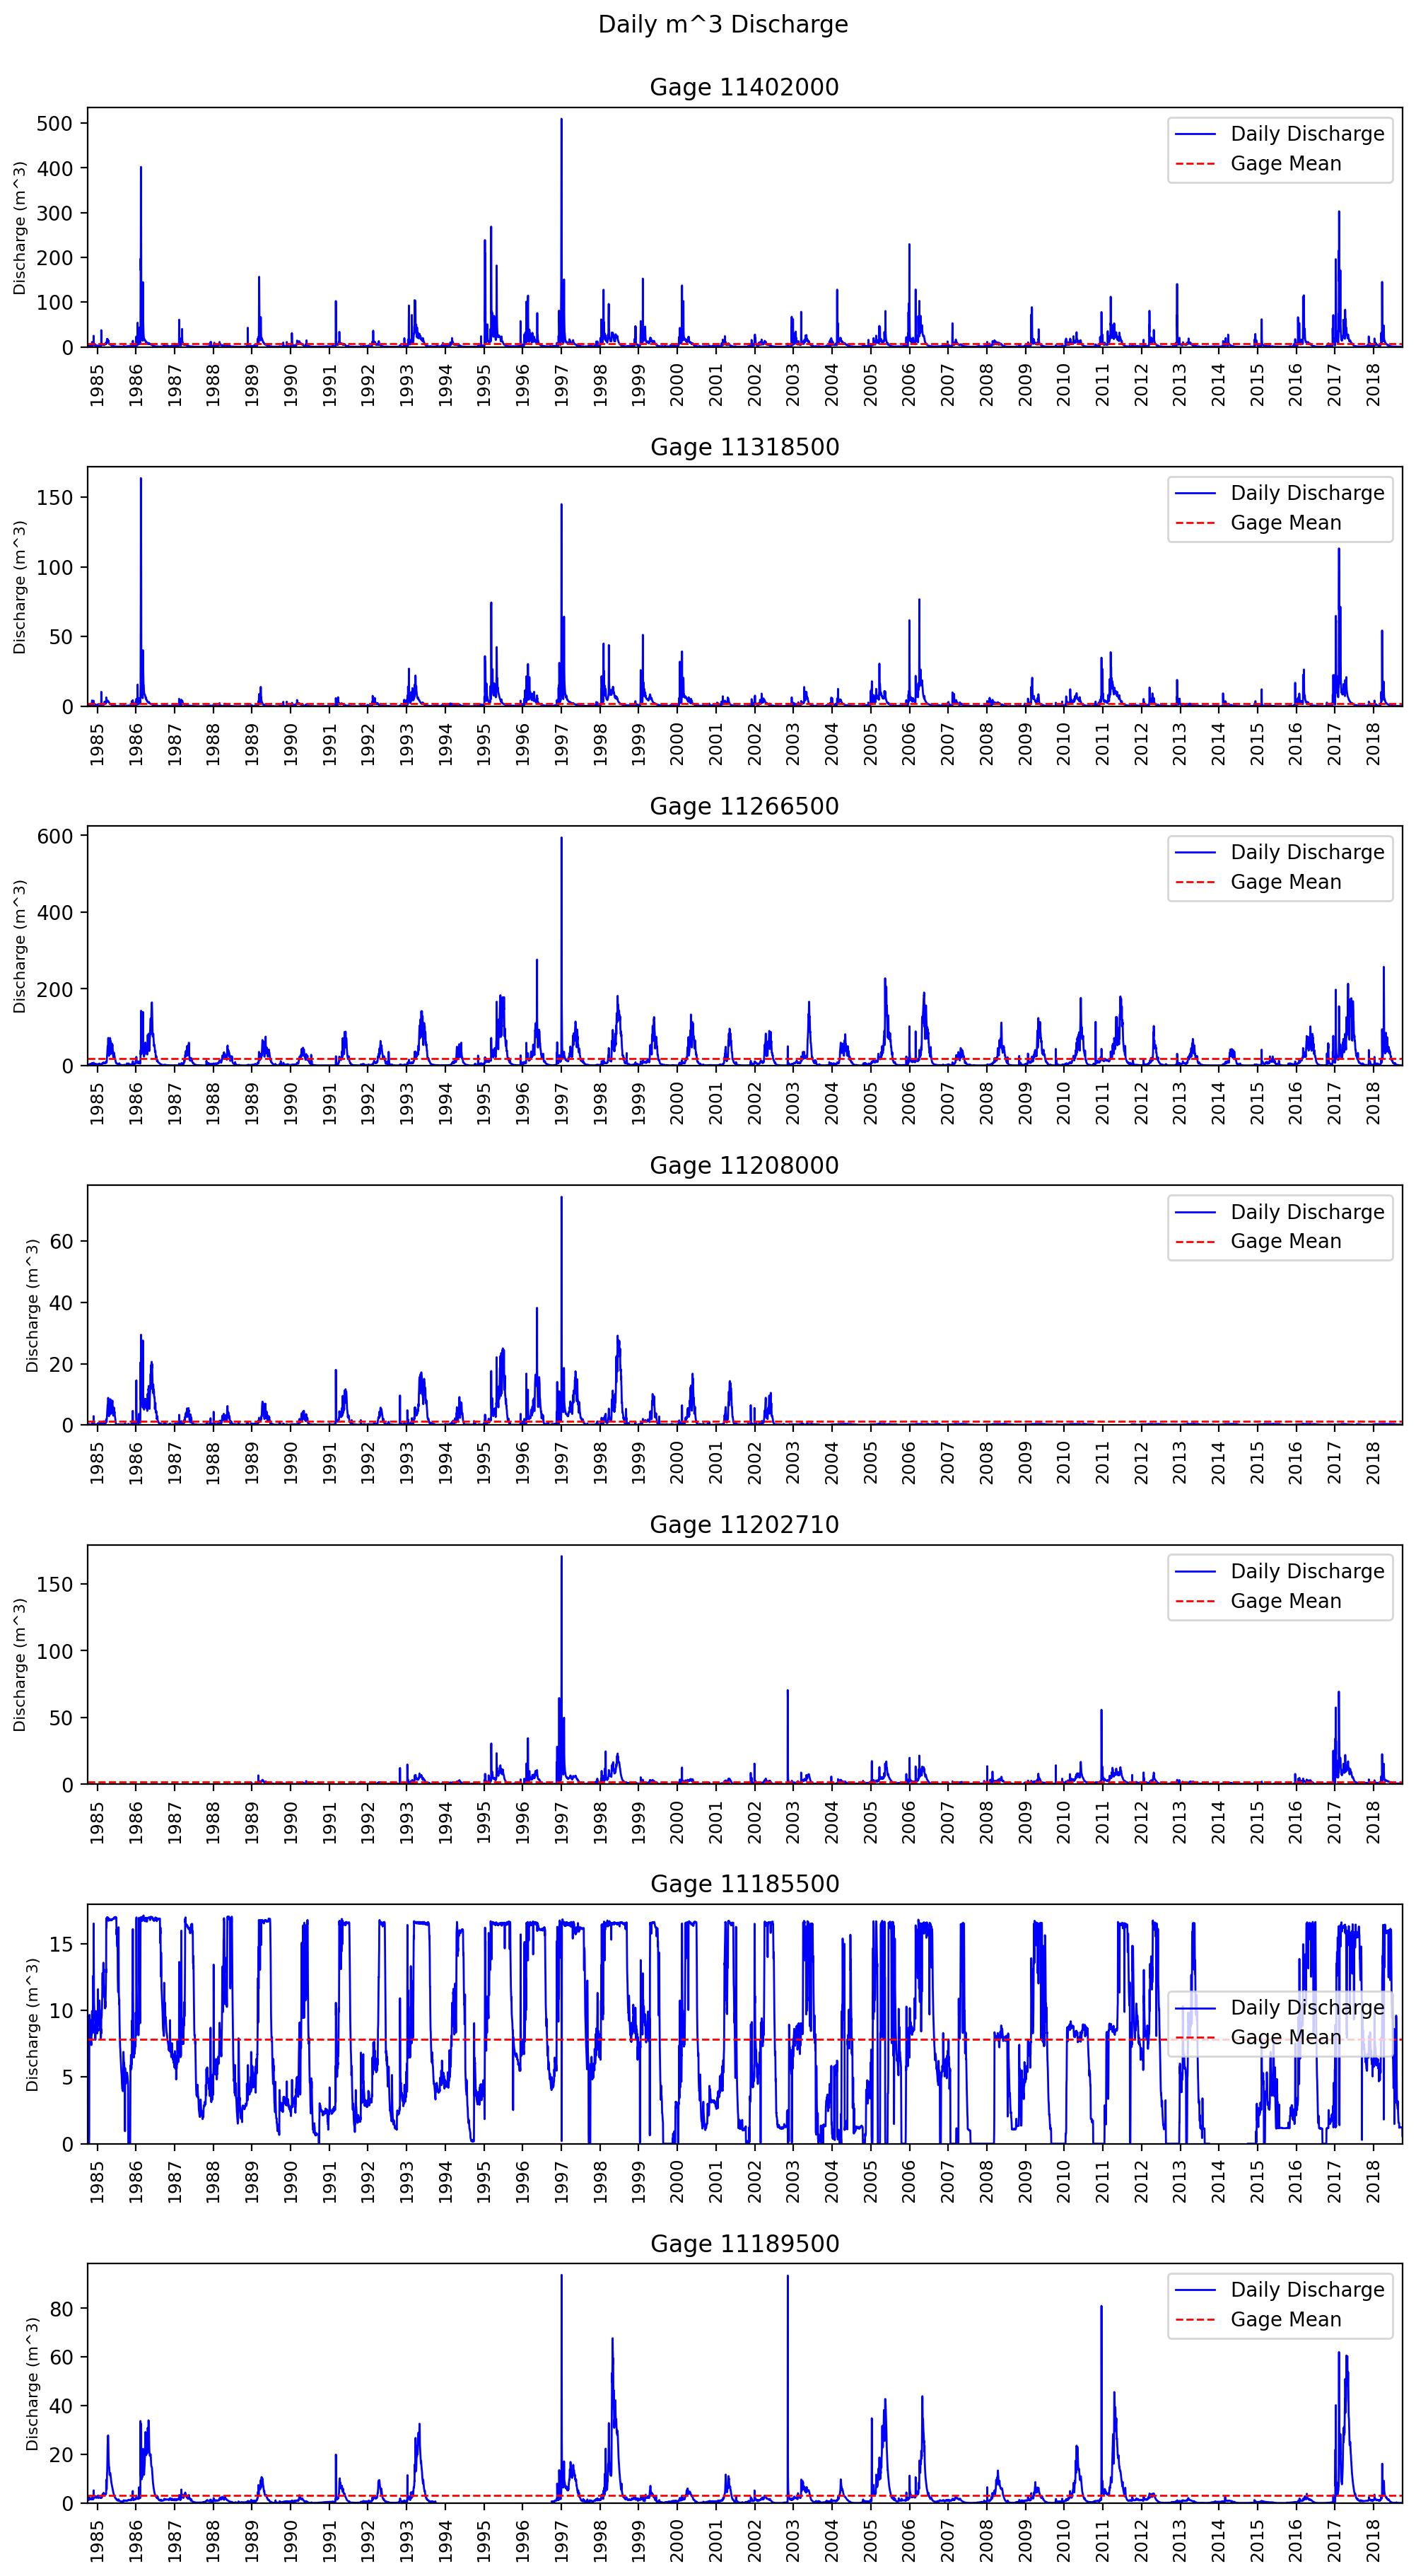

In [11]:
plot_daily_discharge()

#### Observations

* Gage __11208000__ seems to have no/bad data after 2002.
* Gage __11189500__ is missing data in the '90s.
* Gage __11202710__ is missing data in the '80s.
* Gage __11185500__ has very different behavior to the others.
* Some extreme peaks line up between gages (e.g. 1997) suggesting they are driven by the same weather events.

In [12]:
df = df.reset_index()
df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month

In [13]:
def plot_annual_discharge():
    annual_means = df.groupby(["gage", "year"])["m3"].mean()
    annual_means = annual_means.reset_index().set_index("gage").sort_values(by=["year"])
    years = sorted(annual_means["year"].unique())
    fig, axes = plt.subplots(len(gages), 1, figsize=(12, 22), dpi=200)
    for gage, ax in zip(gages, axes.flatten()):
        ax.hlines(gage_avg[gage], xmin=min(years), xmax=max(years), 
                  color="r", linestyle="--", label="Gage Mean")
        ax.plot(annual_means.loc[gage, "year"], annual_means.loc[gage, "m3"], 
                label=f"Year Mean Discharge", color="b", linewidth=1.5)
        ax.set_xlim(min(years), max(years))
        ax.set_xticks(years)
        ax.set_xticklabels(years, rotation=90, fontsize=8)
        ax.set_ylim(0, ax.get_ylim()[1])
        ax.legend()
        ax.set_title(f"Gage {gage}")
        ax.set_ylabel("Discharge (m^3)", fontsize=8)

    fig.suptitle("Annual Average M^3 Discharge", y=0.9)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

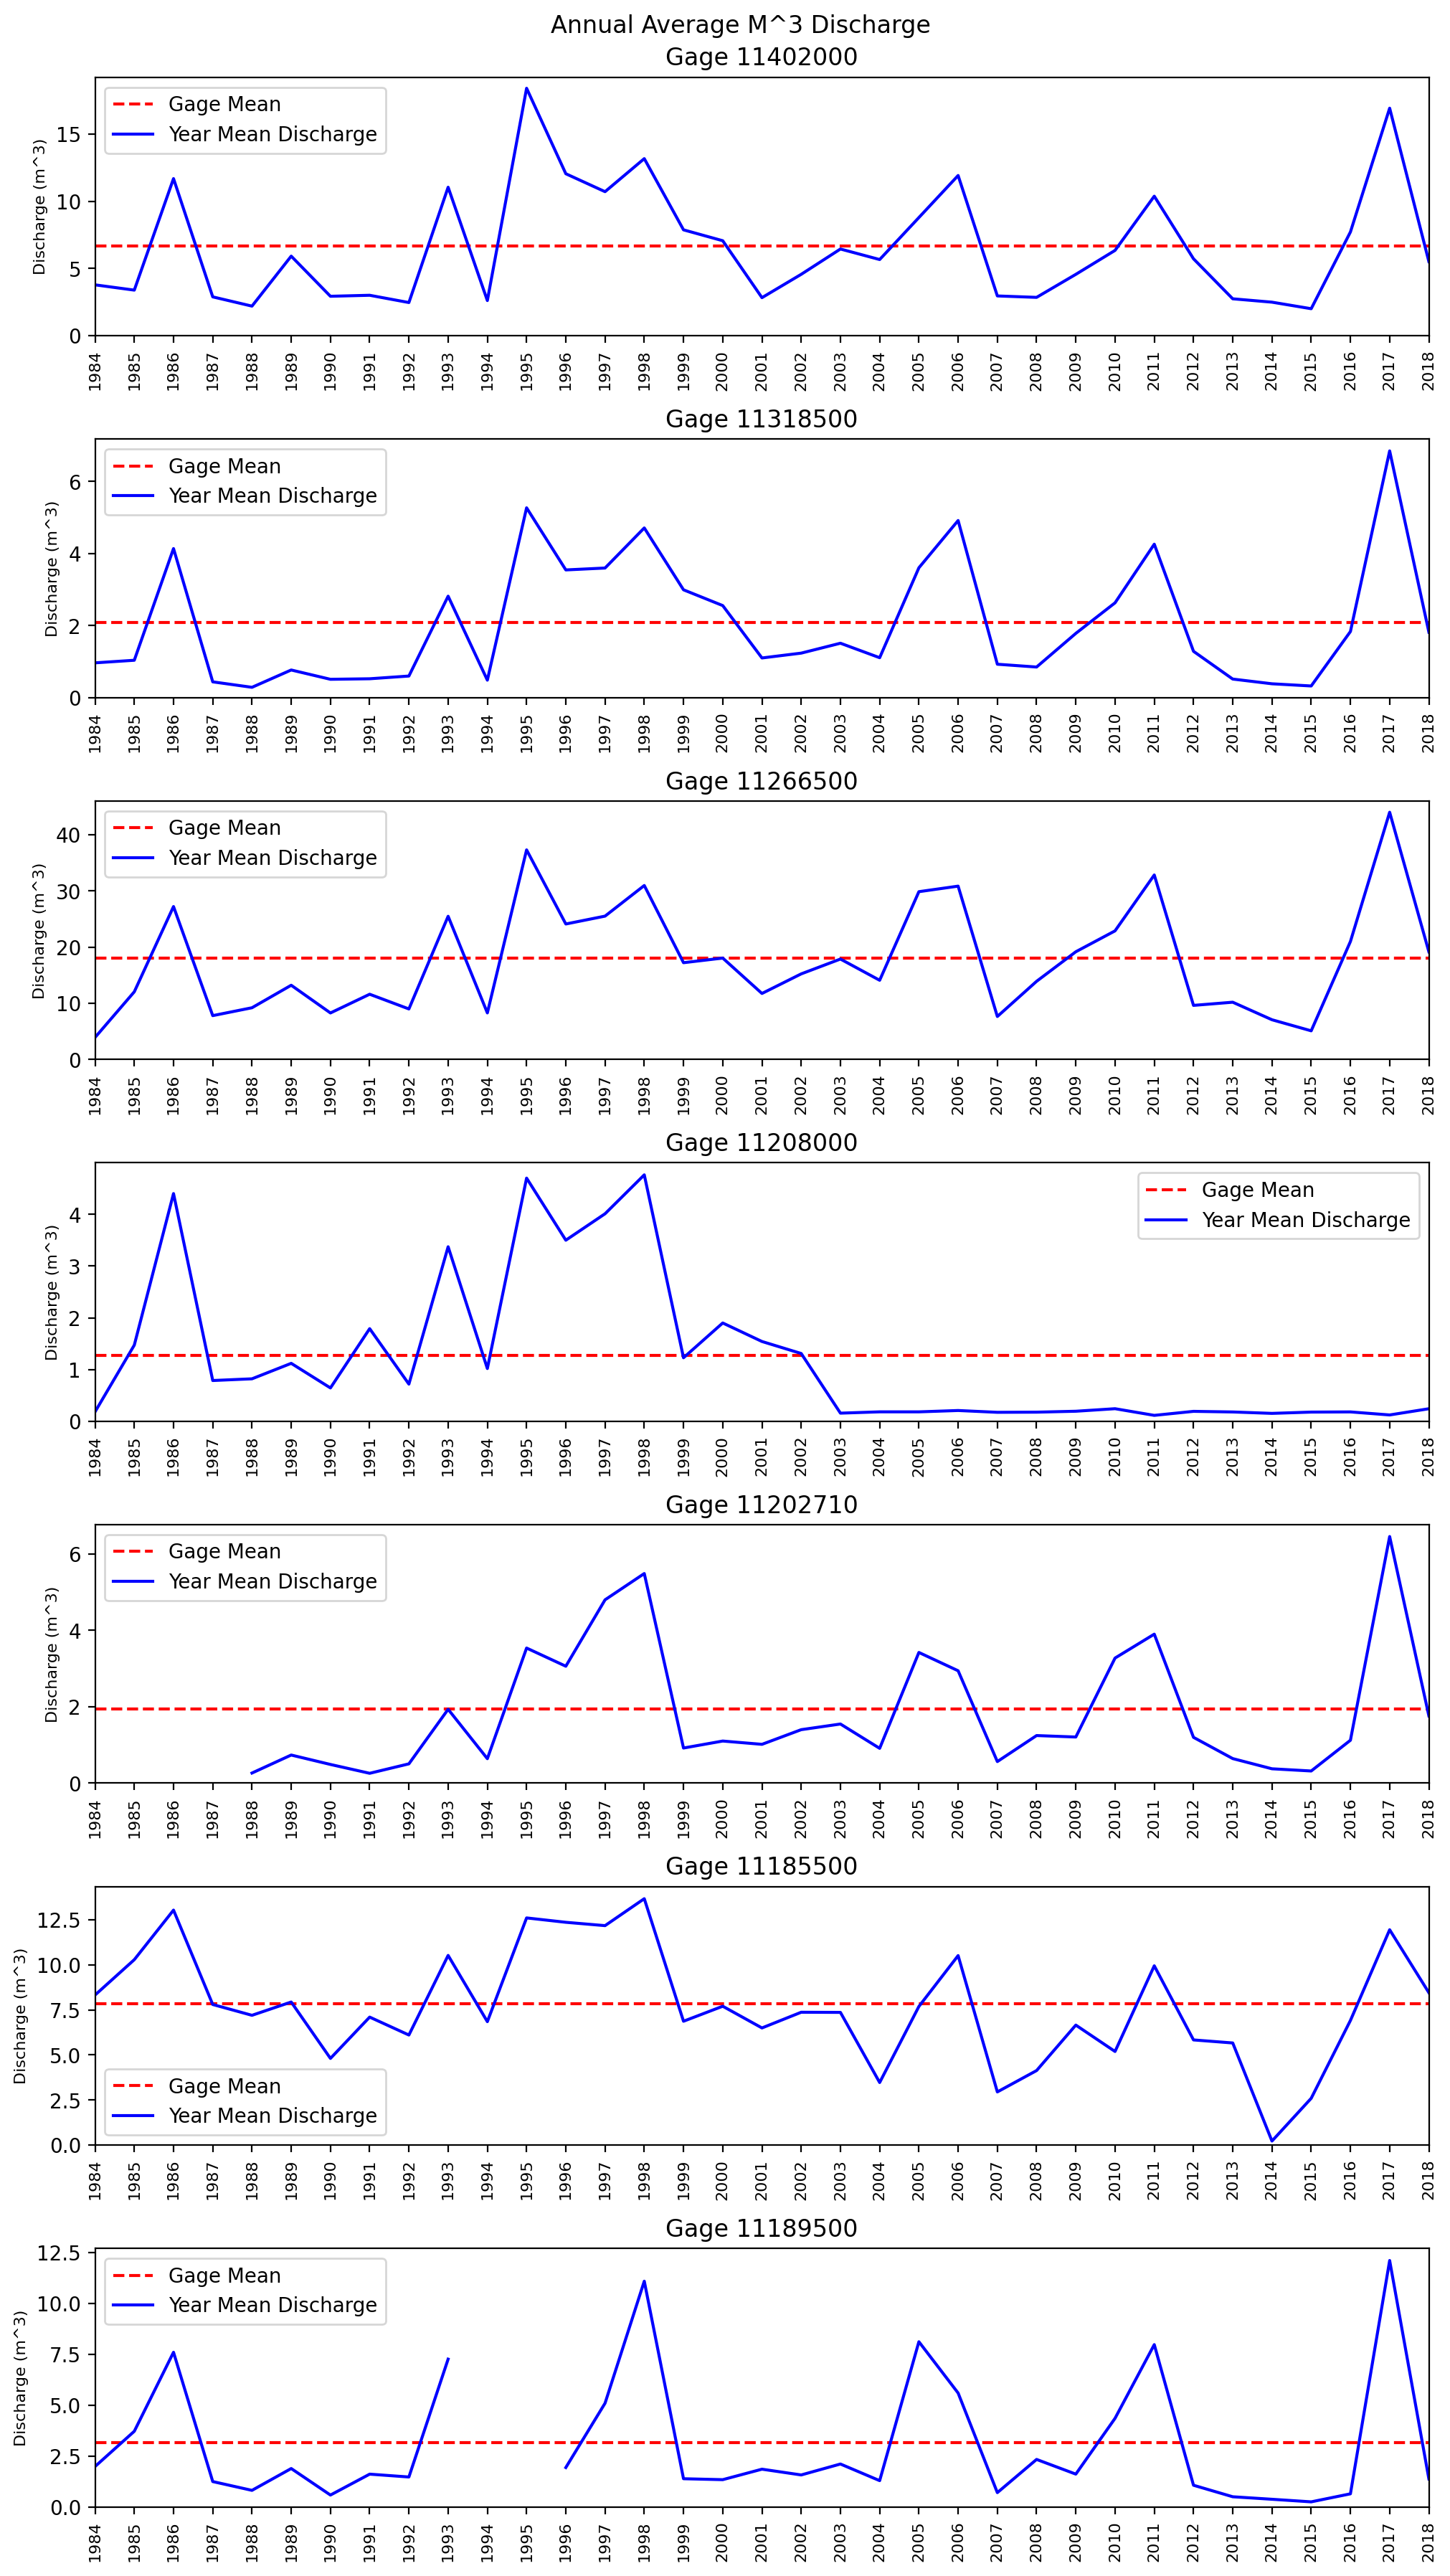

In [14]:
plot_annual_discharge()

#### Observations

* Significant variability in averages in different years.
* Peak and trough years correlated between gages.monthly_df

In [15]:
def plot_monthly_discharge():
    monthly_avg = df.groupby(["gage", "month"])["m3"].mean()
    monthly_avg = monthly_avg.reset_index().set_index("gage").sort_values(by=["month"])
    labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    fig, axes = plt.subplots(len(gages), 1, figsize=(12, 22), dpi=200)
    for gage, ax in zip(gages, axes.flatten()):
        ax.hlines(gage_avg[gage], xmin=1, xmax=12, color="r", linestyle="--", label="Gage Mean")
        ax.plot(monthly_avg.loc[gage, "month"], monthly_avg.loc[gage, "m3"], 
                label=f"Monthly Mean - All Years", color="b", linewidth=2)
        ax.set_xlim(1, 12)
        ax.set_xticks(range(1, 13, 1))
        ax.set_xticklabels(labels, rotation=0)
        ax.set_ylim(0, ax.get_ylim()[1])
        ax.set_title(f"Gage {gage}")
        ax.legend()
        ax.set_ylabel("Discharge (m^3)", fontsize=8)
    fig.suptitle("Average Monthly M^3 Discharge", y=0.91)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

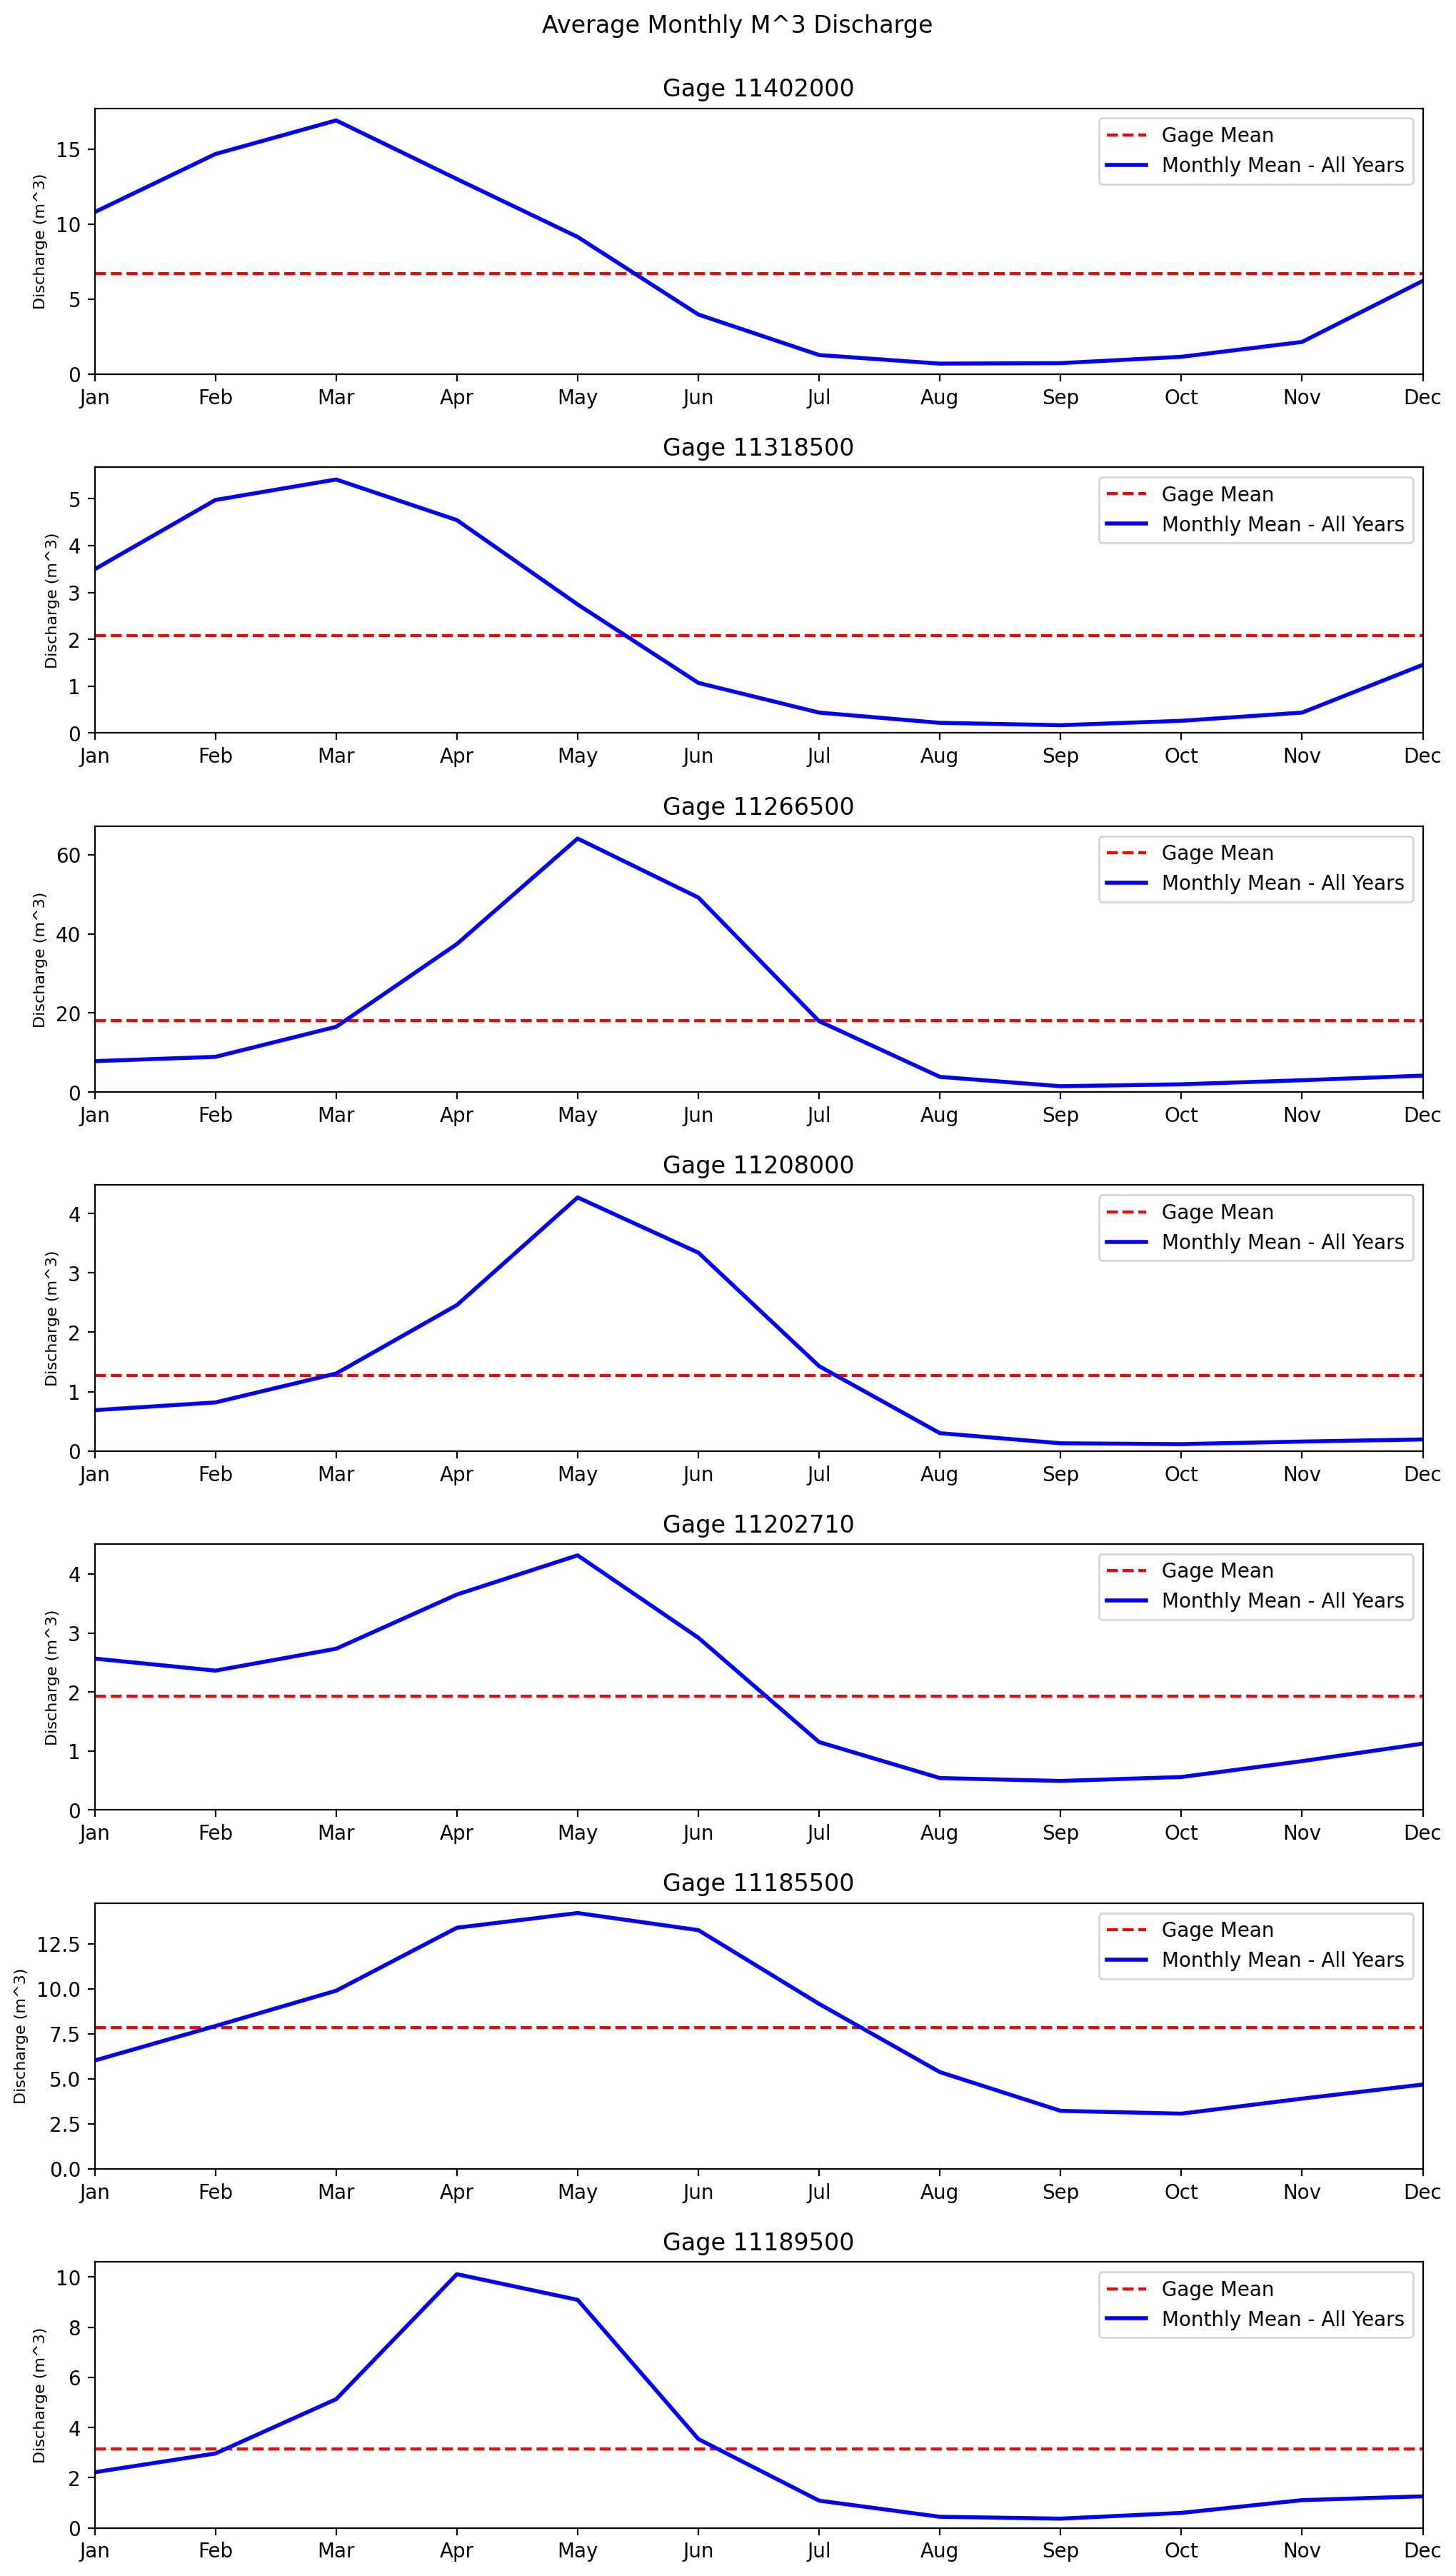

In [16]:
plot_monthly_discharge()

#### Observations

* Across all years there are noticeable seasonal trends, roughly with peaks in Spring and troughs in Fall.
* The seasonal peaks and troughs are different for different gages, with some peaking in each of March/April/May.

In [17]:
# Write full dataset to CSV:

In [18]:
fp = os.path.join(DATA_DIR, "streamgage-full.csv")
columns = ["gage", "time", "ft", "m3"]
df[columns].to_csv(fp, encoding="utf-8", index=False)